In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(style="ticks", font_scale=1.2)
plt.rc("axes.spines", top=False, right=False)

In [2]:
# Define task below. Should be one of the following:
# "capitals-recall", "capitals-recognition", "animals", or "syllogism"
# Change this and run all cells to process the model + human data for a given task.
TASK = "syllogism"

# 0. Helper functions and global variables for plotting

In [3]:
C_VAR = "correct"
I_VAR = "incorrect" if TASK == "syllogism" else "intuitive"

# Define list of models.
MODELS = ["Llama-2-7b-hf", "Llama-2-13b-hf", "Llama-2-70b-hf"] # "gpt2-xl"
def get_vocab_size(model):
    if "gpt2" in model:
        return 50257
    else:
        return 32000
N_LAYERS = {
#     "gpt2": 12, "gpt2-xl": 48, 
    "Llama-2-7b-hf": 32, "Llama-2-13b-hf": 40, "Llama-2-70b-hf": 80
}

# Define list of meta variables for the tasks.
TASK_META_VAR_MAP = {
    "capitals-recall": ["entity", "correct", "intuitive", "population_ratio"],
    "capitals-recognition": ["entity", "correct", "intuitive", "population_ratio"],
    "animals": ["condition", "exemplar", "correct", "intuitive"],
    "syllogism": ["correct", "incorrect", "incorrect_is_intuitive"]
}
TASK_META_VARS = TASK_META_VAR_MAP[TASK]
ITEM_META_VAR_MAP = {
    "capitals-recall": ["model", "item_id"],
    "capitals-recognition": ["model", "item_id", "condition"],
    "animals": ["model", "item_id"],
    "syllogism": ["model", "unique_id", "syllogism_name", "order_first", "is_valid", "is_realistic", "is_consistent"]
}
ITEM_META_VARS = ITEM_META_VAR_MAP[TASK]

# Define output IVs (from the final layer).
OUTPUT_IV_MAP = {
    "entropy_first_token": "output_entropy",
    "reciprocal_rank_correct": "output_rank_correct",
    "first_logprob_correct": "output_logprob_correct",
    "first_logprob_diff": "output_logprobdiff"
}
OLD_OUTPUT_IVS = ["entropy_first_token", "reciprocal_rank_correct", "first_logprob_correct", "first_logprob_diff"]
OUTPUT_IVS = [OUTPUT_IV_MAP[i] for i in OLD_OUTPUT_IVS]
print(f"OUTPUT measures ({len(OUTPUT_IVS)}):", OUTPUT_IVS)

# Define process IVs based purely on probabilities.
PROB_IVS = []
for output_iv in OUTPUT_IVS:
    # Get base name of metric (e.g., "entropy")
    iv = output_iv.replace("output_", "")
    # Add AUC measure(s).
    if iv == "logprobdiff":
        PROB_IVS.append(f"auc_{iv}_pos")
        PROB_IVS.append(f"auc_{iv}_neg")
    else:
        PROB_IVS.append(f"auc_{iv}")
    # Add biggest change measure.
    PROB_IVS.append(f"layer_biggest_change_{iv}")
# Define **control** process IVs.
CONTROL_PROB_IVS = ["control_" + iv for iv in PROB_IVS]

# Define process IVS based on scalar projections.
SCALAR_PROJ_IVS = [
    "auc_boost_pos",
    "auc_boost_neg",
    "layer_argmax_boost"
]

PROCESS_IVS = PROB_IVS + SCALAR_PROJ_IVS + CONTROL_PROB_IVS
print(f"PROCESS measures ({len(PROCESS_IVS)}):", PROCESS_IVS)

def get_metric_group(iv):
    if "entropy" in iv:
        return "Uncertainty"
    elif "rank" in iv or "logprob_correct" in iv:
        return "Confidence"
    elif "logprobdiff" in iv:
        return "Relative confidence"
    elif "boost" in iv:
        return "Boosting"
    else:
        return iv
METRIC_GROUP_PAL = {
    "Uncertainty": "#FF7676FF",
    "Confidence": "#F9D662FF",
    "Relative confidence": "#7CAB7DFF",
    "Boosting": "#75B7D1FF"
}

CONTROL_STYLE = ":"
MAIN_STYLE = "-"

# Helper function for rendering a figure.
FIGURE_DIR = "../../figures"
def render_figure(outpath, render=True):
    if render:
        plt.savefig(f"{FIGURE_DIR}/{outpath}", dpi=300, bbox_inches="tight")
        print(f"Saved figure to {FIGURE_DIR}/{outpath}")
    else:
        print("Not saving figure")

OUTPUT measures (4): ['output_entropy', 'output_rank_correct', 'output_logprob_correct', 'output_logprobdiff']
PROCESS measures (21): ['auc_entropy', 'layer_biggest_change_entropy', 'auc_rank_correct', 'layer_biggest_change_rank_correct', 'auc_logprob_correct', 'layer_biggest_change_logprob_correct', 'auc_logprobdiff_pos', 'auc_logprobdiff_neg', 'layer_biggest_change_logprobdiff', 'auc_boost_pos', 'auc_boost_neg', 'layer_argmax_boost', 'control_auc_entropy', 'control_layer_biggest_change_entropy', 'control_auc_rank_correct', 'control_layer_biggest_change_rank_correct', 'control_auc_logprob_correct', 'control_layer_biggest_change_logprob_correct', 'control_auc_logprobdiff_pos', 'control_auc_logprobdiff_neg', 'control_layer_biggest_change_logprobdiff']


# 1. Read and process model outputs

## Read data and do basic processing

In [4]:
def get_logit_diffs(row, abs_val=False, prefix="", suffix=""):
    correct_logits = row[f"{prefix}logits{suffix}_{C_VAR}"]
    incorrect_logits = row[f"{prefix}logits{suffix}_{I_VAR}"]
    if pd.isna(correct_logits) or pd.isna(incorrect_logits):
        return None
    else:
        if isinstance(correct_logits, str):
            correct_logits = eval(correct_logits)
        if isinstance(incorrect_logits, str):
            incorrect_logits = eval(incorrect_logits)
        first_correct_logit = correct_logits[0]
        first_incorrect_logit = incorrect_logits[0]
        if abs_val:
            return abs(first_correct_logit) - abs(first_incorrect_logit)
        else:
            return first_correct_logit - first_incorrect_logit

def read_model_data(task, data_dir="../../data/model_output"):
    print(f"Reading model data for the following task: {task}")
    dfs = []
    for model in MODELS:
        try:
            df = pd.read_csv(f"{data_dir}/{task}_{model}.csv")
            print(f"Read data for {model}")
        except FileNotFoundError:
            print("Could not find data for:", model, task)
            continue
            
        assert df.layer_idx.nunique() == N_LAYERS[model]
            
        # Add column for whether the layer is the final layer.
        # This is model-dependent.
        max_layer = df["layer_idx"].max()
        df["is_final_layer"] = df["layer_idx"] == max_layer
        
        # Add normalized layer (between 0-1).
        df["layer_01"] = df["layer_idx"] / max_layer
        
        df["model"] = model
        dfs.append(df)
        
    df = pd.concat(dfs).reset_index().drop(columns=["index"])
    
    # Add columns for logprob diffs.
    for metric in ["sum", "mean", "first"]:
        df[f"{metric}_logprob_diff"] = df[f"{metric}_logprob_{C_VAR}"] - df[f"{metric}_logprob_{I_VAR}"]
        df[f"control_{metric}_logprob_diff"] = (
            df[f"control_{metric}_logprob_{C_VAR}"] - \
            df[f"control_{metric}_logprob_{I_VAR}"]
        )

    # Add columns for logit difference and term difference.
    for prefix in ["", "control_"]:
        for suffix in ["", "_deltas"]:
            df[f"{prefix}logit_diff{suffix}"] = df.apply(
                lambda r: get_logit_diffs(r, abs_val=False, prefix=prefix, suffix=suffix),
                axis=1
            )
            df[f"{prefix}term_diff{suffix}"] = df.apply(
                lambda r: get_logit_diffs(r, abs_val=True, prefix=prefix, suffix=suffix),
                axis=1
            )

    # Add column for reciprocal ranks.
    for answer_option in [C_VAR, I_VAR]: # , "control-relevant", "control-irrelevant"]:
        df[f"reciprocal_rank_{answer_option}"] = 1 / df[f"rank_{answer_option}_first_token"]
        df[f"control_reciprocal_rank_{answer_option}"] = 1 / df[f"control_rank_{answer_option}_first_token"]
        
    # Label conditions.
    if task == "syllogism":
        df["logic_belief_consistent"] = (
            df.is_realistic & \
            (((df.syllogism_condition=="consistent")&(df.is_valid)) |
            ((df.syllogism_condition=="violate")&(~df.is_valid)))
        )

    return df

In [5]:
df = read_model_data(TASK)
df.head()

Reading model data for the following task: syllogism
Read data for Llama-2-7b-hf
Read data for Llama-2-13b-hf
Read data for Llama-2-70b-hf


,item_id,unique_id,input,syllogism_name,initial_prompt,order_first,is_realistic,is_nonsense,is_consistent,tags,...,term_diff_deltas,control_logit_diff,control_term_diff,control_logit_diff_deltas,control_term_diff_deltas,reciprocal_rank_correct,control_reciprocal_rank_correct,reciprocal_rank_incorrect,control_reciprocal_rank_incorrect,logic_belief_consistent
0,0,librarians_happy_healthy^consistent^valid,Argument:\nSome librarians are happy people.\n...,librarians_happy_healthy,none,1,True,False,True,"['realistic', 'consistent']",...,-0.070380,-0.091560,0.091560,-1.779214,-1.779214,0.000289,0.000035,0.000041,0.000036,True
1,0,librarians_happy_healthy^consistent^valid,Argument:\nSome librarians are happy people.\n...,librarians_happy_healthy,none,1,True,False,True,"['realistic', 'consistent']",...,3.009111,-1.714876,1.714876,1.858661,1.858661,0.000192,0.000035,0.000051,0.000051,True
2,0,librarians_happy_healthy^consistent^valid,Argument:\nSome librarians are happy people.\n...,librarians_happy_healthy,none,1,True,False,True,"['realistic', 'consistent']",...,1.864206,0.266124,0.266124,0.739649,-0.739649,0.000791,0.000138,0.000061,0.000112,True
3,0,librarians_happy_healthy^consistent^valid,Argument:\nSome librarians are happy people.\n...,librarians_happy_healthy,none,1,True,False,True,"['realistic', 'consistent']",...,0.069063,0.614442,-0.017555,2.179669,2.179669,0.001140,0.000071,0.000065,0.000055,True
4,0,librarians_happy_healthy^consistent^valid,Argument:\nSome librarians are happy people.\n...,librarians_happy_healthy,none,1,True,False,True,"['realistic', 'consistent']",...,0.336894,1.924916,1.924916,-0.827737,0.827737,0.001431,0.000342,0.000123,0.000083,True


## Visualize layer-wise data

Llama-2-7b-hf
Saved figure to ../../figures/syllogism_uncertainty_Llama-2-7b-hf.pdf


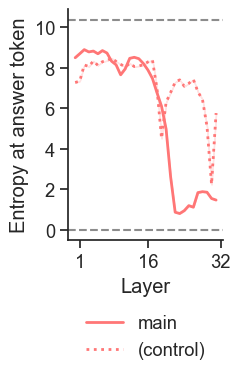

Saved figure to ../../figures/syllogism_confidence_Llama-2-7b-hf.pdf


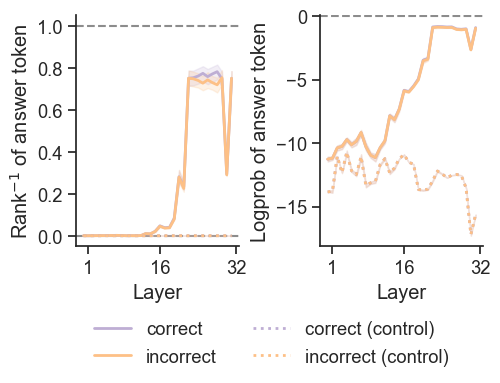

Saved figure to ../../figures/syllogism_relative_confidence_Llama-2-7b-hf.pdf


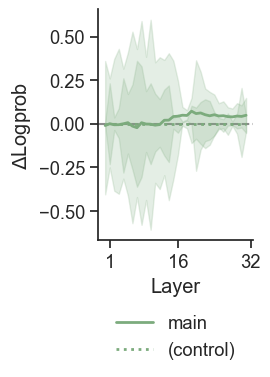

Llama-2-13b-hf
Saved figure to ../../figures/syllogism_uncertainty_Llama-2-13b-hf.pdf


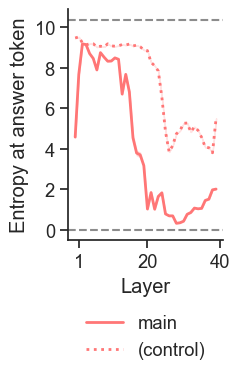

Saved figure to ../../figures/syllogism_confidence_Llama-2-13b-hf.pdf


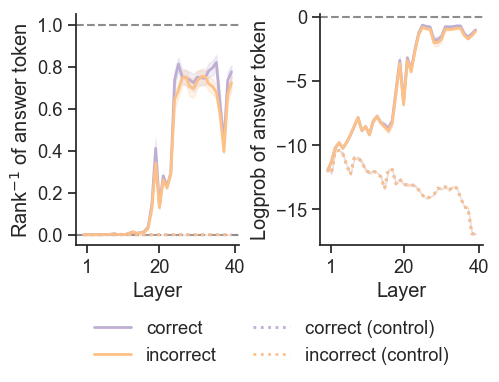

Saved figure to ../../figures/syllogism_relative_confidence_Llama-2-13b-hf.pdf


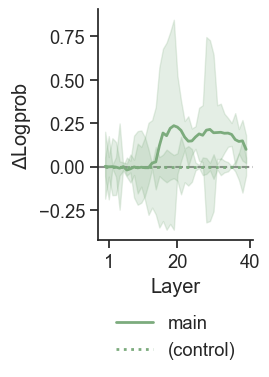

Llama-2-70b-hf
Saved figure to ../../figures/syllogism_uncertainty_Llama-2-70b-hf.pdf


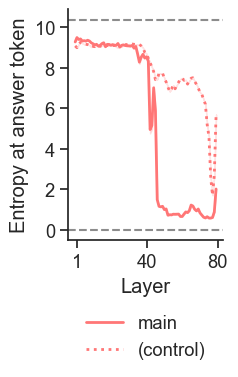

Saved figure to ../../figures/syllogism_confidence_Llama-2-70b-hf.pdf


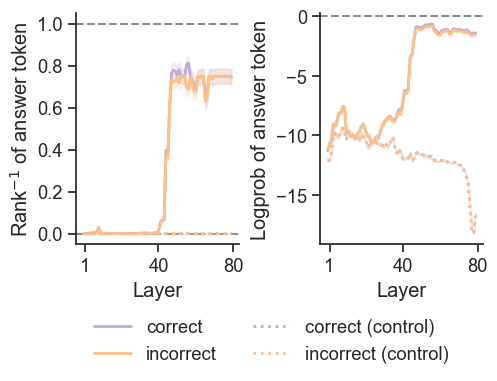

Saved figure to ../../figures/syllogism_relative_confidence_Llama-2-70b-hf.pdf


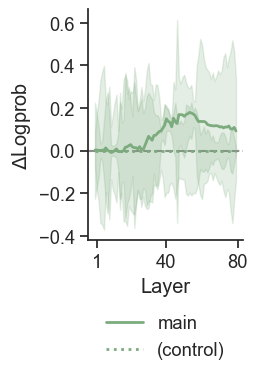

In [6]:
def get_metric_meta_data(metric, model):
    if metric == "reciprocal_rank":
        metric_name = lambda answer_option: f"reciprocal_rank_{answer_option}"
        ylabel = "Rank$^{-1}$ of answer token"
        refs = [1/get_vocab_size(model), 1] # minimum and maximum reciprocal rank
    elif metric == "first_logprob":
        metric_name = lambda answer_option: f"first_logprob_{answer_option}"
        ylabel = "Logprob of answer token"
        refs = [0] # maximum logprob
    elif metric == "entropy":
        metric_name = "entropy_first_token"
        ylabel = "Entropy at answer token"
        refs = [0, np.log(get_vocab_size(model))] # minimum and maximum entropy
    elif metric == "logprobdiff":
        metric_name = "first_logprob_diff"
        ylabel = "$\\Delta$Logprob"
        refs = [0]
    else:
        raise ValueError(f"Unrecognized metric: {metric}")
    return metric_name, ylabel, refs

def plot_layerwise_metric_single(df, metric, model, one_index=True):
    metric_name, ylabel, refs = get_metric_meta_data(metric, model)
    color = METRIC_GROUP_PAL[get_metric_group(metric)]
    for is_control in [False, True]:
        if is_control:
            y = f"control_{metric_name}"
            label = "(control)"
            style = CONTROL_STYLE
        else:
            y = metric_name
            label = "main"
            style = MAIN_STYLE
        ax = sns.lineplot(
            data=df,
            x="layer_idx",
            y=y, 
            lw=2,
            label=label,
            color=color,
            linestyle=style,
        )
        ax.legend(title="", ncols=1, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.25))
        
    if one_index:
        xticks = [1, int(N_LAYERS[model]/2), N_LAYERS[model]]
        ax.set_xticks(xticks, [str(x) for x in xticks])
    ax.set_xlabel("Layer")
    ax.set_ylabel(ylabel)
    for y in refs:
        ax.axhline(y=y, linestyle="--", color="k", alpha=0.5, zorder=-2)
    plt.gcf().set_size_inches(2,3)


def plot_layerwise_metric_group(df, metric_group, model, one_index=True):
    if metric_group == "uncertainty":
        plot_layerwise_metric_single(df, "entropy", model)
    elif metric_group == "relative_confidence":
        plot_layerwise_metric_single(df, "logprobdiff", model)
    elif metric_group == "confidence":
        fig, axes = plt.subplots(nrows=1, ncols=2)

        answer_color_pal = {
            C_VAR: sns.color_palette("Accent")[1],
            I_VAR: sns.color_palette("Accent")[2]
        }
        confidence_metrics= ["reciprocal_rank", "first_logprob"]
        for i, (ax, metric) in enumerate(zip(axes, confidence_metrics)):
            _, ylabel, refs = get_metric_meta_data(metric, model)
            for is_control in [False, True]:
                for answer_option in [C_VAR, I_VAR]:
                    if is_control:
                        y = f"control_{metric}_{answer_option}"
                        label = answer_option + " (control)"
                        style = CONTROL_STYLE
                    else:
                        y = f"{metric}_{answer_option}"
                        label = answer_option
                        style = MAIN_STYLE
                    ax = sns.lineplot(
                        data=df,
                        x="layer_idx",
                        y=y, 
                        lw=2,
                        label=label,
                        color=answer_color_pal[answer_option],
                        linestyle=style,
                        ax=ax
                    )
            if i == 0:
                ax.get_legend().remove()
            else:
                ax.legend(title="", ncols=2, frameon=False, loc="upper center", bbox_to_anchor=(-0.3, -0.25))

            ax.set_xlabel("Layer")
            
            if one_index:
                xticks = [1, int(N_LAYERS[model]/2), N_LAYERS[model]]
                ax.set_xticks(xticks, [str(x) for x in xticks])
            
            ax.set_ylabel(ylabel)
            for y in refs:
                ax.axhline(y=y, linestyle="--", color="k", alpha=0.5, zorder=-2)
        fig.set_size_inches(5.25,3)
        plt.subplots_adjust(wspace=0.5)
    else:
        raise ValueError(f"Unrecognized metric: {metric}")
    
def plot_prob_metric_groups(df, model, task=TASK, render=False, file_suffix="", one_index=True):
    for group in ["uncertainty", "confidence", "relative_confidence"]:
        plot_layerwise_metric_group(df, group, model, one_index=one_index)
        render_figure(f"{task}_{group}{file_suffix}.pdf", render=render)
        plt.show()

for model in df.model.unique():
    print(model)
    plot_prob_metric_groups(
        df[df.model==model], model, task=TASK, file_suffix=f"_{model}", render=True
    )

Llama-2-7b-hf
Saved figure to ../../figures/syllogism_uncertainty_realistic_Llama-2-7b-hf.pdf


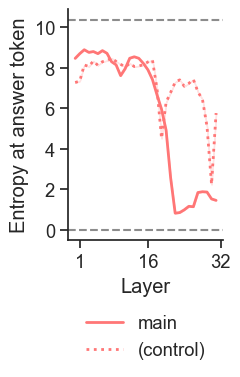

Saved figure to ../../figures/syllogism_confidence_realistic_Llama-2-7b-hf.pdf


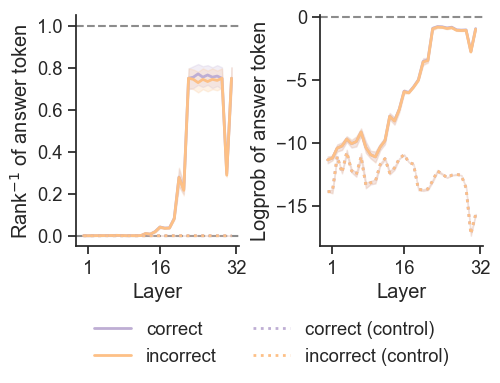

Saved figure to ../../figures/syllogism_relative_confidence_realistic_Llama-2-7b-hf.pdf


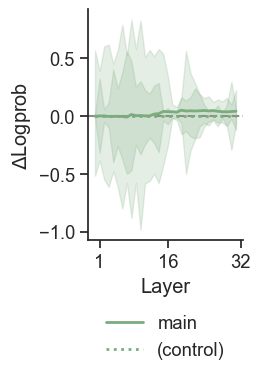

Saved figure to ../../figures/syllogism_uncertainty_consistent_Llama-2-7b-hf.pdf


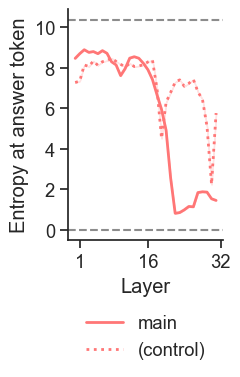

Saved figure to ../../figures/syllogism_confidence_consistent_Llama-2-7b-hf.pdf


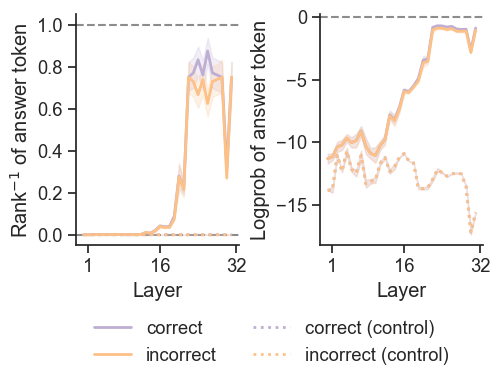

Saved figure to ../../figures/syllogism_relative_confidence_consistent_Llama-2-7b-hf.pdf


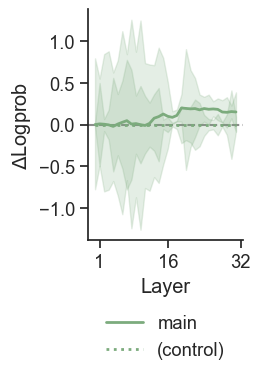

Saved figure to ../../figures/syllogism_uncertainty_inconsistent_Llama-2-7b-hf.pdf


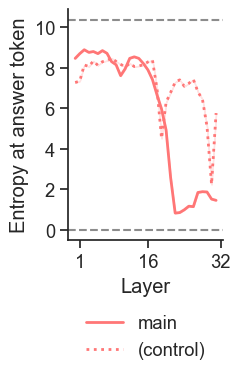

Saved figure to ../../figures/syllogism_confidence_inconsistent_Llama-2-7b-hf.pdf


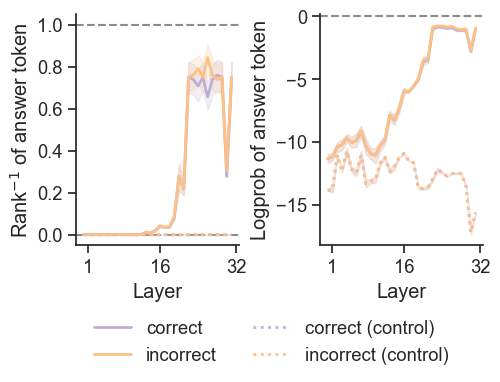

Saved figure to ../../figures/syllogism_relative_confidence_inconsistent_Llama-2-7b-hf.pdf


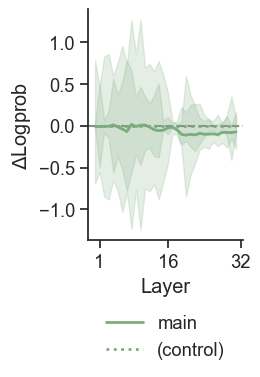

Llama-2-13b-hf
Saved figure to ../../figures/syllogism_uncertainty_realistic_Llama-2-13b-hf.pdf


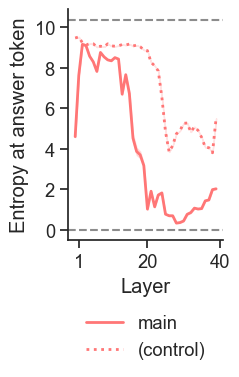

Saved figure to ../../figures/syllogism_confidence_realistic_Llama-2-13b-hf.pdf


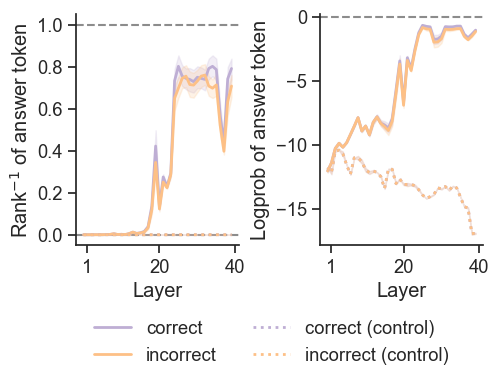

Saved figure to ../../figures/syllogism_relative_confidence_realistic_Llama-2-13b-hf.pdf


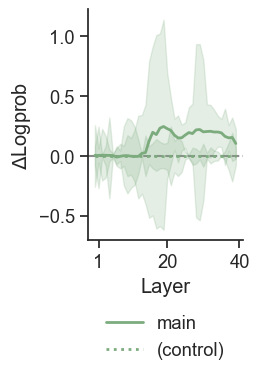

Saved figure to ../../figures/syllogism_uncertainty_consistent_Llama-2-13b-hf.pdf


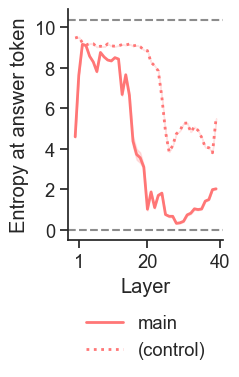

Saved figure to ../../figures/syllogism_confidence_consistent_Llama-2-13b-hf.pdf


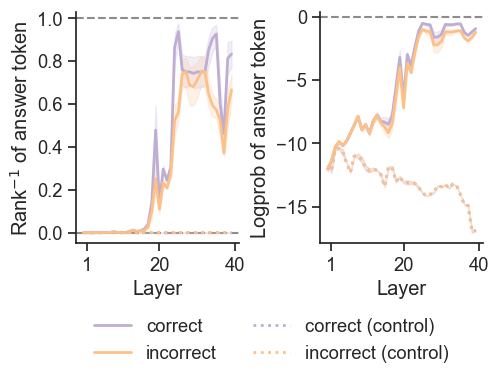

Saved figure to ../../figures/syllogism_relative_confidence_consistent_Llama-2-13b-hf.pdf


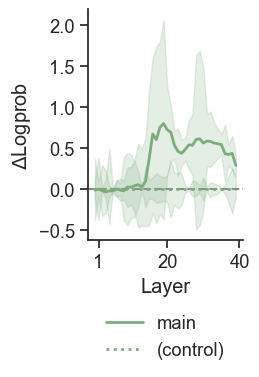

Saved figure to ../../figures/syllogism_uncertainty_inconsistent_Llama-2-13b-hf.pdf


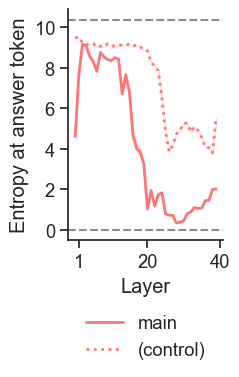

Saved figure to ../../figures/syllogism_confidence_inconsistent_Llama-2-13b-hf.pdf


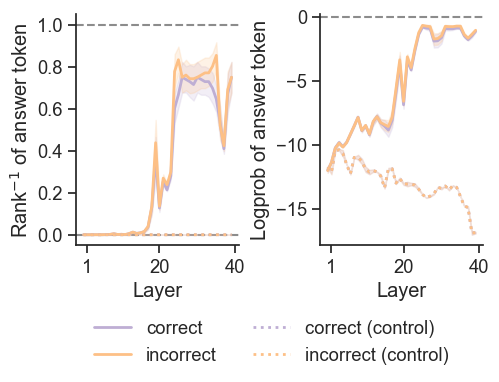

Saved figure to ../../figures/syllogism_relative_confidence_inconsistent_Llama-2-13b-hf.pdf


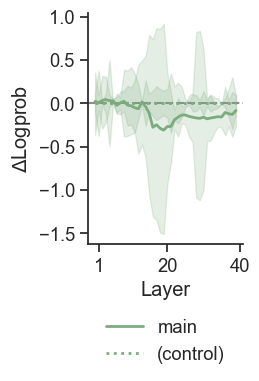

Llama-2-70b-hf
Saved figure to ../../figures/syllogism_uncertainty_realistic_Llama-2-70b-hf.pdf


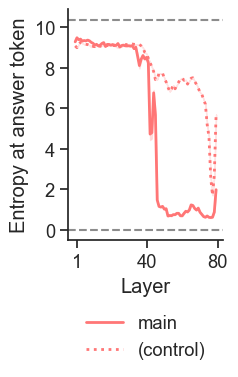

Saved figure to ../../figures/syllogism_confidence_realistic_Llama-2-70b-hf.pdf


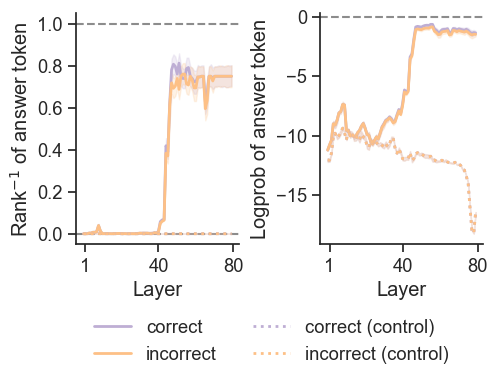

Saved figure to ../../figures/syllogism_relative_confidence_realistic_Llama-2-70b-hf.pdf


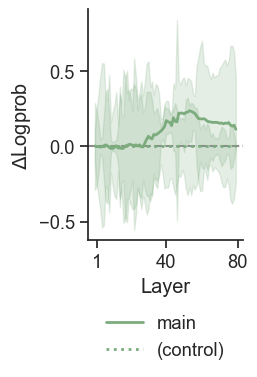

Saved figure to ../../figures/syllogism_uncertainty_consistent_Llama-2-70b-hf.pdf


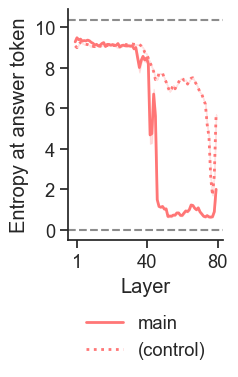

Saved figure to ../../figures/syllogism_confidence_consistent_Llama-2-70b-hf.pdf


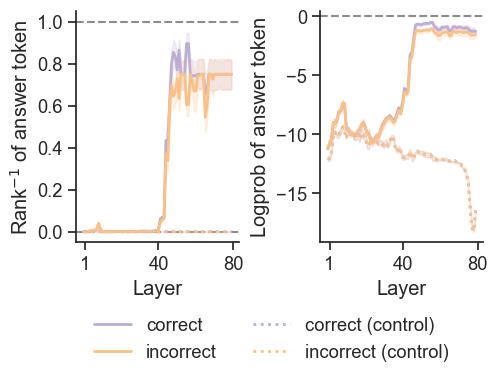

Saved figure to ../../figures/syllogism_relative_confidence_consistent_Llama-2-70b-hf.pdf


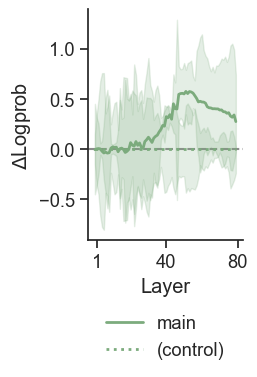

Saved figure to ../../figures/syllogism_uncertainty_inconsistent_Llama-2-70b-hf.pdf


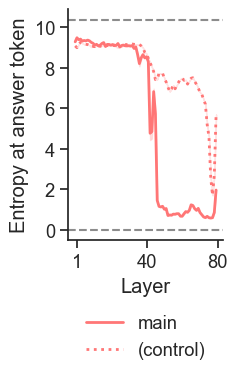

Saved figure to ../../figures/syllogism_confidence_inconsistent_Llama-2-70b-hf.pdf


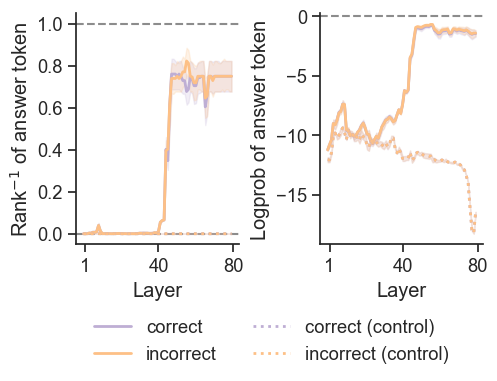

Saved figure to ../../figures/syllogism_relative_confidence_inconsistent_Llama-2-70b-hf.pdf


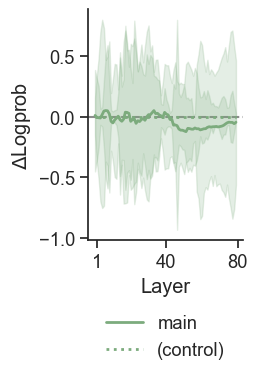

In [7]:
if TASK == "syllogism":
    for model in df.model.unique():
        print(model)
        plot_prob_metric_groups(
            df[(df.is_realistic)&(df.model==model)], 
            model, task=TASK, file_suffix=f"_realistic_{model}", render=True
        )
        plt.show()
        plt.clf()
        plot_prob_metric_groups(
            df[(df.logic_belief_consistent)&(df.model==model)], 
            model, task=TASK, file_suffix=f"_consistent_{model}", render=True
        )
        plt.show()
        plt.clf()
        plot_prob_metric_groups(
            df[(df.is_realistic)&(~df.logic_belief_consistent)&(df.model==model)], 
            model, task=TASK, file_suffix=f"_inconsistent_{model}", render=True
        )
else:
    print(f"Safely skipping this cell (not applicable for task = {TASK})")

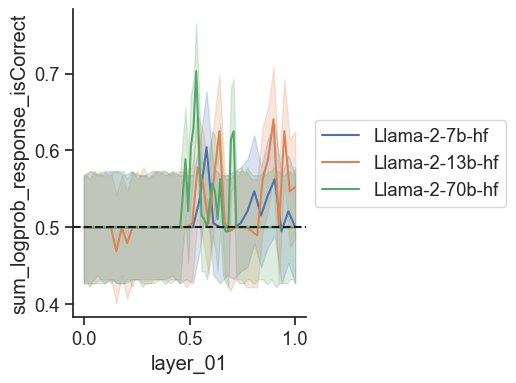

In [8]:
ax = sns.lineplot(
    data=df,
    x="layer_01",
    hue="model",
    y="sum_logprob_response_isCorrect"
)
ax.axhline(0.5, color="k", linestyle="--")
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.gcf().set_size_inches(3,4)

## Compute all metrics not involving scalar projection curves (including output metrics and processing metrics)

In [9]:
def get_index_of_biggest_change(vals, negative_change=False):
    if negative_change:
        vals = -vals
    changes = [vals[i+1] - vals[i] for i in range(0, len(vals)-1)]
    idx = np.argmax(changes)
    return idx

def area_above_0(vals):
    return sum([v for v in vals if v > 0])

def area_below_0(vals):
    return sum([abs(v) for v in vals if v < 0])

def sum_of_neg_vals(vals):
    return sum([v for v in vals if v < 0])

def last_neg_index(vals):
    reversed_index = next((
        i for i, val in enumerate(reversed(vals), 1) if val < 0
    ), None)
    if reversed_index is None:
        return None
    else:
        return len(vals) - reversed_index
    
def get_auc(vals, iv, vocab_size=None):
    if iv == "entropy":
        return vals.sum()
    elif iv == "rank_correct":
        return (vals - (1/vocab_size)).sum()
    elif iv == "logprob_correct":
        return abs(vals).sum()
    elif iv == "logprobdiff":
        pos = area_above_0(vals)
        neg = area_below_0(vals)
        return pos, neg
    else:
        raise ValueError(f"Unrecognized independent variable: {iv}")
        
    
def get_prob_data(df, task=TASK):
#     n_layers = df.layer_idx.nunique()
    index = ITEM_META_VAR_MAP[task]
    if "model" not in index:
        index = ["model"] + index
    
    # Get data corresponding to final layer for output measures.
    final_layer_df = df[df.is_final_layer].set_index(index)
    
    df = df.set_index(index)
    
    results = []
    for ind in df.index.unique():
        item_data = df.loc[ind]
        # By construction, "model" should be the first element of `ind`
        model = ind[0]
        n_layers = N_LAYERS[model]
        # There should be one value per layer
        assert len(item_data) == n_layers
        
        # ~~~~~~~~~~~~~~~~~~~~~ Initialize metadata about the stimulus.
        meta_data = {k: item_data[k].values[0] for k in TASK_META_VARS}
        for i, index_var in enumerate(index):
            meta_data[index_var] = ind[i]
            
        # ~~~~~~~~~~~~~~~~~~~~~ Add output metrics from final layer.
        output_data = {}
        for output_iv in OLD_OUTPUT_IVS:
            new_iv = OUTPUT_IV_MAP[output_iv]
            output_data[new_iv] = final_layer_df.loc[ind][output_iv]

        # ~~~~~~~~~~~~~~~~~~~~~ Compute processing metrics.
        process_data = {}
        
        for var_name, clean_var_name in OUTPUT_IV_MAP.items():
            # Get base name of metric. Should be one of the following: 
            # "entropy", "rank_correct", "logprob_correct", "logprobdiff"
            iv = clean_var_name.replace("output_", "")
            
            # Add metrics for both MAIN and CONTROL evaluations.
            for is_control in [False, True]:
                if is_control:
                    prefix = "control_"
                else:
                    prefix = ""
            
                # Add AUC measure(s).
                data = item_data[prefix + var_name]
                auc = get_auc(data, iv, vocab_size=get_vocab_size(model))
                if iv == "logprobdiff":
                    auc_pos, auc_neg = auc
                    process_data[prefix + f"auc_{iv}_pos"] = auc_pos
                    process_data[prefix + f"auc_{iv}_neg"] = auc_neg
                else:
                    process_data[prefix + f"auc_{iv}"] = auc

                # Add biggest change measure.
                layer_biggest_change = get_index_of_biggest_change(
                    data,
                    negative_change=(iv == "entropy")
                )
                process_data[prefix + f"layer_biggest_change_{iv}"] = layer_biggest_change
        
        # Combine meta data, output metrics, and processing metrics.
        res = meta_data | output_data | process_data
        results.append(res)
        
    results = pd.DataFrame(results)
    return results

In [10]:
# Process probability-based metrics.
prob_data = get_prob_data(df, task=TASK)
print(prob_data.model.unique())
prob_data.sort_values(by=ITEM_META_VAR_MAP[TASK]).head()

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_27801/468398554.py:54: PerformanceWarning: indexing past lexsort depth may impact performance.
  item_data = df.loc[ind]


['Llama-2-7b-hf' 'Llama-2-13b-hf' 'Llama-2-70b-hf']


,correct,incorrect,incorrect_is_intuitive,model,unique_id,syllogism_name,order_first,is_valid,is_realistic,is_consistent,...,auc_logprob_correct,layer_biggest_change_logprob_correct,control_auc_logprob_correct,control_layer_biggest_change_logprob_correct,auc_logprobdiff_pos,auc_logprobdiff_neg,layer_biggest_change_logprobdiff,control_auc_logprobdiff_pos,control_auc_logprobdiff_neg,control_layer_biggest_change_logprobdiff
202,invalid,valid,True,Llama-2-13b-hf,computers_electronics_expensive^consistent^inv...,computers_electronics_expensive,1,False,True,True,...,221.411699,20,513.696845,1,19.279642,33.530815,27,12.923537,9.741781,4
203,invalid,valid,True,Llama-2-13b-hf,computers_electronics_expensive^consistent^inv...,computers_electronics_expensive,2,False,True,True,...,221.984976,20,513.696845,1,18.255253,35.356687,27,12.923537,9.741781,4
200,valid,invalid,False,Llama-2-13b-hf,computers_electronics_expensive^consistent^valid,computers_electronics_expensive,1,True,True,True,...,195.340528,20,516.878601,15,41.686309,12.279117,30,9.741781,12.923537,3
201,valid,invalid,False,Llama-2-13b-hf,computers_electronics_expensive^consistent^valid,computers_electronics_expensive,2,True,True,True,...,195.253567,20,516.878601,15,40.832536,12.661329,30,9.741781,12.923537,3
206,invalid,valid,False,Llama-2-13b-hf,computers_electronics_expensive^violate^invalid,computers_electronics_expensive,1,False,True,False,...,206.368515,20,513.696845,1,45.075357,21.511011,27,12.923537,9.741781,4


In [11]:
print("Checking that all metrics before scalar projections are in the columns:")
for iv in OUTPUT_IVS + PROB_IVS + CONTROL_PROB_IVS:
    print("  * ", iv, "-->", iv in prob_data.columns)

Checking that all metrics before scalar projections are in the columns:
  *  output_entropy --> True
  *  output_rank_correct --> True
  *  output_logprob_correct --> True
  *  output_logprobdiff --> True
  *  auc_entropy --> True
  *  layer_biggest_change_entropy --> True
  *  auc_rank_correct --> True
  *  layer_biggest_change_rank_correct --> True
  *  auc_logprob_correct --> True
  *  layer_biggest_change_logprob_correct --> True
  *  auc_logprobdiff_pos --> True
  *  auc_logprobdiff_neg --> True
  *  layer_biggest_change_logprobdiff --> True
  *  control_auc_entropy --> True
  *  control_layer_biggest_change_entropy --> True
  *  control_auc_rank_correct --> True
  *  control_layer_biggest_change_rank_correct --> True
  *  control_auc_logprob_correct --> True
  *  control_layer_biggest_change_logprob_correct --> True
  *  control_auc_logprobdiff_pos --> True
  *  control_auc_logprobdiff_neg --> True
  *  control_layer_biggest_change_logprobdiff --> True


# 2. Compute layer-delta projection curves

## Helper functions

In [12]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors `v1` and `v2`:
        >>> angle_between((1, 0, 0), (0, 1, 0))
        1.5707963267948966
        >>> angle_between((1, 0, 0), (1, 0, 0))
        0.0
        >>> angle_between((1, 0, 0), (-1, 0, 0))
        3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

Llama-2-7b-hf
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_Llama-2-7b-hf.pdf


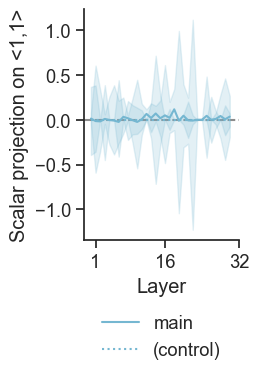

Llama-2-13b-hf
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_Llama-2-13b-hf.pdf


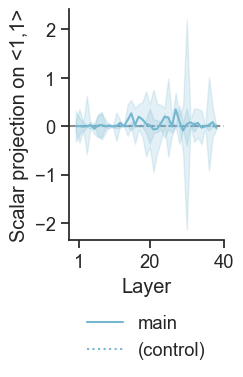

Llama-2-70b-hf
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_Llama-2-70b-hf.pdf


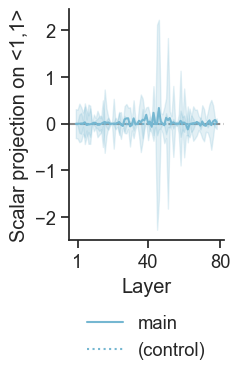

In [13]:
def projection_curve(
    df, 
    task=TASK,
    meta_vars=TASK_META_VARS, 
    render=False,
    ax=None,
    tick_all_layers=False,
    file_suffix="",
    one_index=True
):
    layer_var = "layer_idx"
    assert df.model.nunique()==1
    model = df.model.unique()[0]

    ax = plt.gca()
    all_proj_data = []
    for is_control in [False, True]:
        if is_control:
            x = "control_term_diff_deltas"
            y = "control_logit_diff_deltas"
            linestyle = ":"
            label = "(control)"
            prefix = "control_"
        else:
            x = "term_diff_deltas"
            y = "logit_diff_deltas"
            linestyle = "-"
            label = "main"
            prefix = ""

        # Compute projections for each item and layer.
        meta_vars = ITEM_META_VAR_MAP[task] + TASK_META_VAR_MAP[task]
        print(meta_vars)
        proj_data = df.set_index(meta_vars + [layer_var])[[x, y]].reset_index()
        proj_data[f"{prefix}norm_xy"] = np.linalg.norm(proj_data[[x, y]], ord=2, axis=1)
        proj_data[f"{prefix}angle"] = proj_data.apply(
            lambda r: angle_between([r[x], r[y]], [1,1]),
            axis=1
        )
        proj_data[f"{prefix}scalar_projection"] = np.cos(proj_data[f"{prefix}angle"]) * proj_data[f"{prefix}norm_xy"]
        all_proj_data.append(proj_data)
        
        kws = dict(
            data=proj_data,
            x=layer_var,
            y=f"{prefix}scalar_projection",
            err_kws={"lw": 1},
            markersize=5,
            ax=ax
        )
        ax = sns.lineplot(
            color=METRIC_GROUP_PAL["Boosting"],
            linestyle=linestyle,
            label=label,
            **kws,
        )
    
    if tick_all_layers:
        ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90, size="xx-small")
    elif one_index:
        xticks = [1, int(N_LAYERS[model]/2), N_LAYERS[model]]
        ax.set_xticks(xticks, [str(x) for x in xticks])
    ax.set_xlabel("Layer")
    ax.set_ylabel("Scalar projection on <1,1>")
    ax.axhline(y=0, linestyle="--", color="k", alpha=0.5, zorder=-2)
    ax.legend(title="", ncols=1, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.25))
    plt.gcf().set_size_inches(2,3)
    
    proj_data = pd.merge(*all_proj_data)
    
    if render:
        render_figure(f"{task}_boosting{file_suffix}.pdf", render=render)
    plt.show()
    return ax, proj_data

proj_data = []
for model in df.model.unique():
    print(model)
    ax, model_proj_data = projection_curve(
        df[df.model==model], 
        task=TASK,
        file_suffix=f"_{model}",
        render=True
    )
    proj_data.append(model_proj_data)
proj_data = pd.concat(proj_data)

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_realistic_Llama-2-7b-hf.pdf


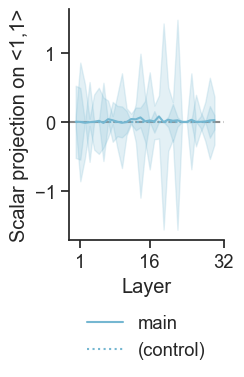

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_consistent_Llama-2-7b-hf.pdf


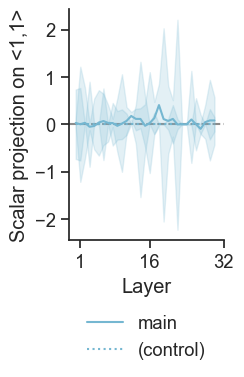

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_inconsistent_Llama-2-7b-hf.pdf


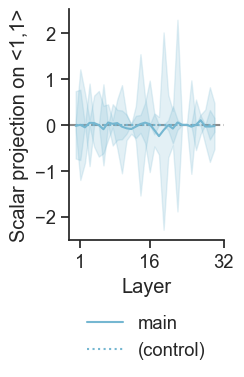

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_realistic_Llama-2-13b-hf.pdf


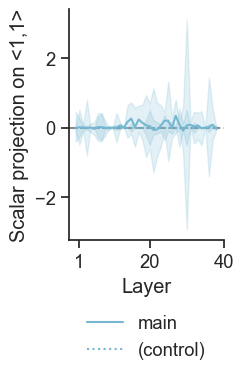

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_consistent_Llama-2-13b-hf.pdf


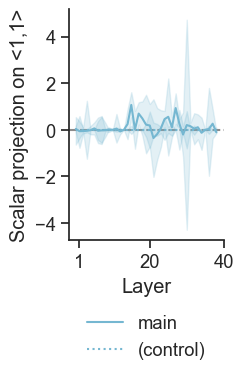

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_inconsistent_Llama-2-13b-hf.pdf


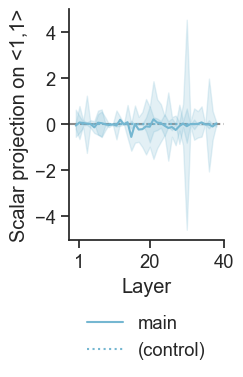

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_realistic_Llama-2-70b-hf.pdf


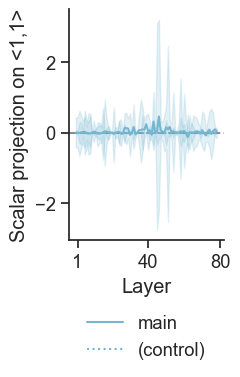

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_consistent_Llama-2-70b-hf.pdf


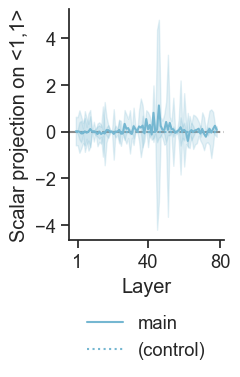

['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent', 'correct', 'incorrect', 'incorrect_is_intuitive']
Saved figure to ../../figures/syllogism_boosting_inconsistent_Llama-2-70b-hf.pdf


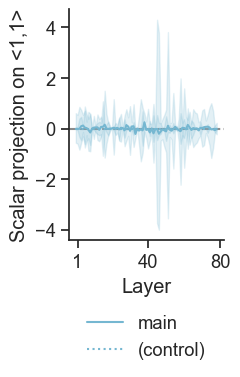

In [14]:
if TASK == "syllogism":
    for model in df.model.unique():
        _, _ = projection_curve(
            df[(df.is_realistic)&(df.model==model)], 
            task=TASK, file_suffix=f"_realistic_{model}", render=True
        )
        plt.show()
        plt.clf()
        _, _ = projection_curve(
            df[(df.logic_belief_consistent)&(df.model==model)], 
            task=TASK, file_suffix=f"_consistent_{model}", render=True
        )
        plt.show()
        plt.clf()
        _, _ = projection_curve(
            df[(df.is_realistic)&(~df.logic_belief_consistent)&(df.model==model)], 
            task=TASK, file_suffix=f"_inconsistent_{model}", render=True
        )
else:
    print(f"Safely skipping this cell (not applicable for task = {TASK})")

# 3. Summarize projection curves

In [15]:
def summarize_projection_curve(df, proj_data, task=TASK):
    index = ITEM_META_VAR_MAP[task]
    if "model" not in index:
        index = ["model"] + index
    print("Indexing on:", index)
    df = df.set_index(index)
    proj_data = proj_data.dropna().set_index(index)
    
    # Compute summary metrics of the projection curve.
    summary = []
    
    for ind in proj_data.index.unique():
        # Get projection data corresponding to this particular item.
        data = proj_data.loc[ind]
        model = ind[0]

        # There should be one value per layer (or layer delta).
        assert np.array_equal(data["layer_idx"], range(N_LAYERS[model]-1))
        vals = data["scalar_projection"].values

        # Add metadata.
        res = {}
        for i, index_var in enumerate(index):
            res[index_var] = ind[i] if len(index) > 1 else ind
        for t in TASK_META_VAR_MAP[task]:
            res[t] = df.loc[ind][t].values[0]
            
        # Add curve summary measures (AUC and max layer).
        res[f"auc_boost_neg"] = area_below_0(vals)
        res[f"auc_boost_pos"] = area_above_0(vals)
        res[f"layer_argmax_boost"] = np.argmax(vals)
            
        summary.append(res)
    summary = pd.DataFrame(summary)
    return summary

In [16]:
curve_summary = summarize_projection_curve(
    df, proj_data, task=TASK
)

# Combine with probability-based data.
print("Combining curve-based data with probability-based data")
_p = prob_data.set_index(ITEM_META_VARS)
for metric in OUTPUT_IVS + PROB_IVS + CONTROL_PROB_IVS:
    print(metric)
    curve_summary[metric] = curve_summary.apply(
        lambda r: _p.loc[*(r[i] for i in ITEM_META_VARS)][metric],
        axis=1
    )

if TASK == "animals":
    print("Adding German annotations")
    # Annotate with the original German names, for compatibility with human data.
    stims = pd.read_csv("../../data/stimuli/animals.csv").set_index("exemplar")
    curve_summary["exemplar_de"] = curve_summary.exemplar.apply(
        lambda e: stims.loc[e]["exemplar_de"]
    )

curve_summary.head()

Indexing on: ['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid', 'is_realistic', 'is_consistent']


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_27801/3273315020.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = proj_data.loc[ind]
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_27801/3273315020.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  res[t] = df.loc[ind][t].values[0]


Combining curve-based data with probability-based data
output_entropy
output_rank_correct
output_logprob_correct
output_logprobdiff
auc_entropy
layer_biggest_change_entropy
auc_rank_correct
layer_biggest_change_rank_correct
auc_logprob_correct
layer_biggest_change_logprob_correct
auc_logprobdiff_pos
auc_logprobdiff_neg
layer_biggest_change_logprobdiff
control_auc_entropy
control_layer_biggest_change_entropy
control_auc_rank_correct
control_layer_biggest_change_rank_correct
control_auc_logprob_correct
control_layer_biggest_change_logprob_correct
control_auc_logprobdiff_pos
control_auc_logprobdiff_neg
control_layer_biggest_change_logprobdiff


,model,unique_id,syllogism_name,order_first,is_valid,is_realistic,is_consistent,correct,incorrect,incorrect_is_intuitive,...,layer_biggest_change_logprobdiff,control_auc_entropy,control_layer_biggest_change_entropy,control_auc_rank_correct,control_layer_biggest_change_rank_correct,control_auc_logprob_correct,control_layer_biggest_change_logprob_correct,control_auc_logprobdiff_pos,control_auc_logprobdiff_neg,control_layer_biggest_change_logprobdiff
0,Llama-2-7b-hf,librarians_happy_healthy^consistent^valid,librarians_happy_healthy,1,True,True,True,valid,invalid,False,...,22,233.499131,29,0.002164,3,398.071501,1,21.128054,7.700087,1
1,Llama-2-7b-hf,librarians_happy_healthy^consistent^valid,librarians_happy_healthy,2,True,True,True,valid,invalid,False,...,22,233.499131,29,0.002164,3,398.071501,1,21.128054,7.700087,1
2,Llama-2-7b-hf,librarians_happy_healthy^consistent^invalid,librarians_happy_healthy,1,False,True,True,invalid,valid,True,...,19,233.499131,29,0.001248,14,411.499468,30,7.700087,21.128054,14
3,Llama-2-7b-hf,librarians_happy_healthy^consistent^invalid,librarians_happy_healthy,2,False,True,True,invalid,valid,True,...,19,233.499131,29,0.001248,14,411.499468,30,7.700087,21.128054,14
4,Llama-2-7b-hf,librarians_happy_healthy^violate^valid,librarians_happy_healthy,1,True,True,False,valid,invalid,True,...,22,233.499131,29,0.002164,3,398.071501,1,21.128054,7.700087,1


In [17]:
print(curve_summary.model.unique())
curve_summary.to_csv(
    f"../../data/model_output/processed/{TASK}_metrics.csv", index=False
)

['Llama-2-7b-hf' 'Llama-2-13b-hf' 'Llama-2-70b-hf']


# 4. Combine with human data

In [18]:
def zscore_col(df, col, group="subject_id"):
    ppt_means = df.groupby(group)[col].mean()
    ppt_stds = df.groupby(group)[col].std()
    df[f"{col}_zscore"] = df.apply(
        lambda r: (r[col]-ppt_means.loc[r[group]]) / ppt_stds.loc[r[group]],
        axis=1
    )
    return df

def combine_model_human_data(model_df, task=TASK):
    assert model_df.model.nunique()==1
    # Read human trial-level data.
    if task == "capitals-recall":
        trial_df = pd.read_csv(
            f"../../data/human/{TASK}_trial_labeled.csv"
        )
    else:
        trial_df = pd.read_csv(
            f"../../data/human/{TASK}_trial.csv"
        )
        if task == "animals":
            trial_df = trial_df.rename(columns={"correct": "response_correct"})
      
    print(f"Read data for task = {task}")
    print("Num rows:", len(trial_df))
    
    if task != "syllogism":
        subject_var = "subject_id" if task.startswith("capitals") else "subject_nr"
        print("Num unique subjects:", trial_df[subject_var].nunique())
    
    ivs = OUTPUT_IVS + PROCESS_IVS
    
    if task.startswith("capitals"):
        model_index = "entity"
        human_index = "entity"
    elif task == "syllogism":
        model_index = "unique_id"
        human_index = "unique_id"
    elif task == "animals":
        model_index = "exemplar_de"
        human_index = "Exemplar"
        ivs += TASK_META_VARS
        # Add z-scored RTs within participant.
        trial_df = zscore_col(trial_df, "RT", group="subject_nr")
        
    # Add model-derived measures to human trial-level data.
    print(model_df.columns)
    model_df = model_df.set_index(model_index)
    for iv in ivs:
        # For capitals-recall and animals there will only be one value,
        # but for capitals-recognition and syllogism we need to take the mean 
        # across the two test conditions (correct_first and intuitive_first,
        # or the two orderings of premises in the argument)
        if task == "capitals-recognition" or task == "syllogism":
            trial_df[iv] = trial_df.apply(
                lambda r: model_df.loc[r[human_index]][iv].mean() if r[human_index] in model_df.index else None,
                axis=1
            )
        else:
            trial_df[iv] = trial_df.apply(
                lambda r: model_df.loc[r[human_index]][iv],
                axis=1
            )

    return trial_df

for model in curve_summary.model.unique():
    trials = combine_model_human_data(curve_summary[curve_summary.model==model], task=TASK)
    trials.to_csv(
        f"../../data/human_model_combined/{TASK}_{model}.csv", 
        index=False
    )
    trials.head()

Read data for task = syllogism
Num rows: 959
Index(['model', 'unique_id', 'syllogism_name', 'order_first', 'is_valid',
       'is_realistic', 'is_consistent', 'correct', 'incorrect',
       'incorrect_is_intuitive', 'auc_boost_neg', 'auc_boost_pos',
       'layer_argmax_boost', 'output_entropy', 'output_rank_correct',
       'output_logprob_correct', 'output_logprobdiff', 'auc_entropy',
       'layer_biggest_change_entropy', 'auc_rank_correct',
       'layer_biggest_change_rank_correct', 'auc_logprob_correct',
       'layer_biggest_change_logprob_correct', 'auc_logprobdiff_pos',
       'auc_logprobdiff_neg', 'layer_biggest_change_logprobdiff',
       'control_auc_entropy', 'control_layer_biggest_change_entropy',
       'control_auc_rank_correct', 'control_layer_biggest_change_rank_correct',
       'control_auc_logprob_correct',
       'control_layer_biggest_change_logprob_correct',
       'control_auc_logprobdiff_pos', 'control_auc_logprobdiff_neg',
       'control_layer_biggest_change